In [2]:
import yt 
import trident
import numpy as np
import matplotlib.pyplot as plot

## Main Idea:

Test the four main ways that I know of for getting Column Densities / Spectra

1. yt array
2. trident lightray
3. yt absorption spectrum
4. trident spectrum (this won't give me the column density directly but I can compare it to the yt one

If these give the same values at different column densities and look like what's in the proejction than I really don't know what's going on with Kate's data.

In [3]:
##Read in the data from Jason
#fn = "RD0042/RD0042"
fn = "~/snap_m25n256_125.hdf5"
ds = yt.load(fn)

yt : [INFO     ] 2017-03-13 13:57:32,513 Calculating time from 8.000e-01 to be 3.419e+17 seconds
yt : [INFO     ] 2017-03-13 13:57:32,518 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2017-03-13 13:57:32,583 Parameters: current_time              = 3.41920801326e+17 s
yt : [INFO     ] 2017-03-13 13:57:32,585 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-03-13 13:57:32,587 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-03-13 13:57:32,589 Parameters: domain_right_edge         = [ 25000.  25000.  25000.]
yt : [INFO     ] 2017-03-13 13:57:32,593 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-03-13 13:57:32,595 Parameters: current_redshift          = 0.25000000501
yt : [INFO     ] 2017-03-13 13:57:32,596 Parameters: omega_lambda              = 0.7
yt : [INFO     ] 2017-03-13 13:57:32,597 Parameters: omega_matter              = 0.3
yt : [INFO     ] 2017-03-13 13:57:32,599 Parameters: hubble_constant        

In [10]:
val, pos = ds.find_max(('deposit', 'PartType0_density'))

yt : [INFO     ] 2017-03-13 14:00:05,154 Max Value is 7.72102e-21 at 5857.9921722412109375 5615.5681610107421875 9384.1075897216796875


In [12]:
#ds.derived_field_list
print pos

[ 5857.99217224  5615.56816101  9384.10758972] code_length


In [13]:
## Create a ray that corresponds to a "z" projection, a distance 5 kpc from the center of the halo.
## pos = ds.arr([0.4992466,0.4545078,0.50523567],'code_length') --> this is for the Jason sin
pos = ds.arr([5857.99217224,5615.56816101,9384.10758972],'code_length')
dx = ds.arr(50,'kpc').in_units('code_length')
ray_start = [pos[0]+dx,pos[1],0]
ray_end   = [pos[0]+dx,pos[1],1]

In [14]:
## Here's where it creates the yt ray object
ytray = ds.ray(ray_start,ray_end)

In [15]:
## Creating the trident lightray object
line_list = ['H I 1216']
#triray = trident.make_simple_ray(ds,ray_start,ray_end,lines=line_list)
triray = trident.make_simple_ray(ds,ray_start,ray_end,lines=line_list,ftype='PartType0'

yt : [WARNING  ] 2017-03-13 14:00:43,017 Adding grid-based ion fields to SPH dataset. This is probably wrong.
yt : [WARNING  ] 2017-03-13 14:00:43,018 To correct, change `ftype` in make_simple_ray() to SPH field type.
yt : [INFO     ] 2017-03-13 14:00:43,052 Getting segment at z = 0.25000000501: [ 0.23448969  0.22462273  0.        ] unitary to [  2.34489687e-01   2.24622726e-01   4.00000000e-05] unitary.
//anaconda/lib/python2.7/site-packages/yt/units/yt_array.py:975: RuntimeWarning: invalid value encountered in divide
  return super(YTArray, self).__div__(ro)
yt : [INFO     ] 2017-03-13 14:00:43,131 Getting subsegment: [0.23448968689 unitary, 0.22462272644 unitary, 0.0 unitary] to [0.23448968689 unitary, 0.22462272644 unitary, 4e-05 unitary].


KeyboardInterrupt: 

In [ ]:
#Making a trident spectrum
sg = trident.SpectrumGenerator(lambda_min=1180.,lambda_max=1240.,dlambda=0.01)
sg.make_spectrum(triray,lines=line_list)

In [9]:
ytcoldens = np.sum(ytray[('gas','H_number_density')]*ytray['dz'].in_cgs())
print ytcoldens

4.89649484163e+21 cm**(-2)


In [10]:
triad = triray.all_data()
tricoldens = np.sum(triad[('gas','H_number_density')]*triad[('gas', 'dl')])
print tricoldens

4.89649484163e+21 cm**(-2)


So at least the two ray objects are giving the same values so that's good

## So of course it seems like trident won't report the column densities. 

So just going ahead and getting the information I want directly from yt:

In [19]:
## Now let's make a yt AbsorptionSpectrum
## This lets us access the column density assigned to the spectrum!

from yt.analysis_modules.absorption_spectrum.api import AbsorptionSpectrum

sp = AbsorptionSpectrum(1180.0, 1240.0, 10001)

In [20]:
my_label = 'HI Lya'
field = 'H_number_density'
wavelength = 1215.6700 # Angstroms
f_value = 4.164E-01
gamma = 6.265e+08
mass = 1.00794

sp.add_line(my_label, field, wavelength, f_value, gamma, mass, label_threshold=1.e10)

In [21]:
wavelength,flux = sp.make_spectrum(triray,output_absorbers_file='absorbers.txt')

yt : [INFO     ] 2017-03-10 13:59:54,826 Creating spectrum
Adding line - HI Lya [1215.670000 A]: : 100%|██████████| 527/527 [00:04<00:00, 107.88it/s]
yt : [INFO     ] 2017-03-10 13:59:59,788 Writing absorber list: absorbers.txt.


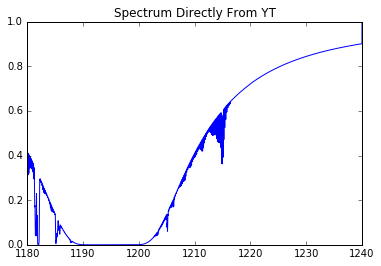

In [35]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

plt.plot(wavelength,flux)
plt.xlim()
plt.title('Spectrum Directly From YT')

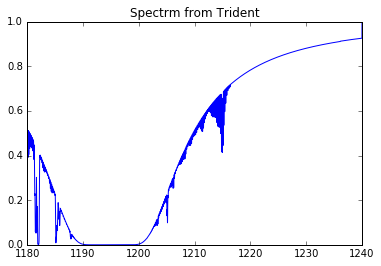

In [36]:
plt.plot(sg.lambda_field,sg.flux_field)
plt.title('Spectrm from Trident')

#### So it's producing the same spectra which is reassuring since one's built off the other.

In [34]:
data = np.genfromtxt('absorbers.txt')
print 'Column '
np.sum(data[:,3])

4.8964953123168337e+21

In [50]:
ytcoldens = np.sum(ytray['H_number_density']*ytray['dz'].in_cgs())
print 'YT Array Coldens:', ytcoldens
triad = triray.all_data()
tricoldens = np.sum(triad['H_number_density']*triad[('gas', 'dl')])
print 'Trident Array Coldens:', tricoldens
print 'Spectrum Column Density:', np.sum(data[:,3])

YT Array Coldens: 4.89649484163e+21 cm**(-2)


yt : [INFO     ] 2017-03-10 14:41:46,133 Allocating for 5.270e+02 particles (index particle type 'all')
yt : [INFO     ] 2017-03-10 14:41:46,141 Identified 3.130e+02 octs


Trident Array Coldens: 4.89649484163e+21 cm**(-2)
Spectrum Column Density: 4.89649531232e+21


### So all of the methods I can think of to get the column density out of yt produce the same values. 

#### The only other thing I want to try is if the same thing is true at a column density that's much lower. 

In [47]:
pos = ds.arr([0.4992466,0.4545078,0.50523567],'code_length')
dx = ds.arr(50,'kpc').in_units('code_length')
ray_start2 = [pos[0]+dx,pos[1],0]
ray_end2   = [pos[0]+dx,pos[1],1]

ytray2 = ds.ray(ray_start2,ray_end2)
triray2 = trident.make_simple_ray(ds,ray_start2,ray_end2,lines=line_list)



my_label = 'HI Lya'
field = 'H_number_density'
wavelength = 1215.6700 # Angstroms
f_value = 4.164E-01
gamma = 6.265e+08
mass = 1.00794
sp2 = AbsorptionSpectrum(1140.0, 1240.0, 10001)
sp2.add_line(my_label, field, wavelength, f_value, gamma, mass, label_threshold=1.e10)
wavelength,flux = sp2.make_spectrum(triray,output_absorbers_file='absorbers_50.txt')

data2 = np.genfromtxt('absorbers_50.txt')

ytcoldens2 = np.sum(ytray2['H_number_density']*ytray2['dz'].in_cgs())
print 'YT Array Coldens:', ytcoldens2
triad2 = triray2.all_data()
tricoldens2 = np.sum(triad2['H_number_density']*triad2[('gas', 'dl')])
print 'Trident Array Coldens:', tricoldens2
print 'Spectrum Column Density:', np.sum(data2[:,3])

yt : [INFO     ] 2017-03-10 14:30:33,103 Getting segment at z = 4.4408920985e-16: [ 0.4995941  0.4545078  0.       ] unitary to [ 0.4995941  0.4545078  1.       ] unitary.
yt : [INFO     ] 2017-03-10 14:30:33,111 Getting subsegment: [0.4995941 unitary, 0.4545078 unitary, 0.0 unitary] to [0.4995941 unitary, 0.4545078 unitary, 1.0 unitary].
yt : [INFO     ] 2017-03-10 14:30:33,531 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2017-03-10 14:30:34,094 Parameters: current_time              = 4.3430653996e+17
yt : [INFO     ] 2017-03-10 14:30:34,096 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-03-10 14:30:34,097 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-03-10 14:30:34,100 Parameters: domain_right_edge         = [  4.43982386e+26   4.43982386e+26   4.43982386e+26]
yt : [INFO     ] 2017-03-10 14:30:34,102 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-03-10 14:30:34,103 Parameters: current_redshift         

YT Array Coldens: 2.23364839208e+15 cm**(-2)


yt : [INFO     ] 2017-03-10 14:30:34,851 Allocating for 4.870e+02 particles (index particle type 'all')
yt : [INFO     ] 2017-03-10 14:30:34,858 Identified 2.890e+02 octs


Trident Array Coldens: 2.23364839208e+15 cm**(-2)
Spectrum Column Density: 2.23364838903e+15


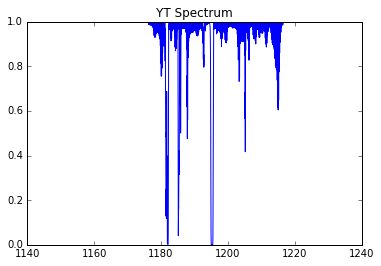

In [52]:
plt.plot(wavelength,flux)
plt.title('YT Spectrum')

yt : [INFO     ] 2017-03-10 14:45:22,282 Getting segment at z = 4.4408920985e-16: [ 0.4995941  0.4545078  0.       ] unitary to [ 0.4995941  0.4545078  1.       ] unitary.
yt : [INFO     ] 2017-03-10 14:45:22,288 Getting subsegment: [0.4995941 unitary, 0.4545078 unitary, 0.0 unitary] to [0.4995941 unitary, 0.4545078 unitary, 1.0 unitary].
yt : [INFO     ] 2017-03-10 14:45:23,003 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2017-03-10 14:45:23,446 Parameters: current_time              = 4.3430653996e+17
yt : [INFO     ] 2017-03-10 14:45:23,446 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-03-10 14:45:23,448 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-03-10 14:45:23,449 Parameters: domain_right_edge         = [  4.43982386e+26   4.43982386e+26   4.43982386e+26]
yt : [INFO     ] 2017-03-10 14:45:23,451 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-03-10 14:45:23,454 Parameters: current_redshift         

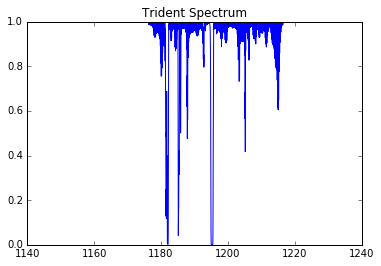

In [58]:
pos = ds.arr([0.4992466,0.4545078,0.50523567],'code_length')
dx = ds.arr(50,'kpc').in_units('code_length')
ray_start2 = [pos[0]+dx,pos[1],0]
ray_end2   = [pos[0]+dx,pos[1],1]

triray2 = trident.make_simple_ray(ds,ray_start2,ray_end2,lines=line_list)


sg2 = trident.SpectrumGenerator(lambda_min=1140.,lambda_max=1240.,dlambda=0.01)
sg2.make_spectrum(triray2,lines=line_list)

plt.plot(sg2.lambda_field,sg2.flux_field)
plt.title('Trident Spectrum')

yt : [INFO     ] 2017-03-10 14:50:21,953 Projection completed
yt : [INFO     ] 2017-03-10 14:50:21,955 xlim = 0.498135 0.500359
yt : [INFO     ] 2017-03-10 14:50:21,957 ylim = 0.453396 0.455620
yt : [INFO     ] 2017-03-10 14:50:21,960 xlim = 0.498135 0.500359
yt : [INFO     ] 2017-03-10 14:50:21,962 ylim = 0.453396 0.455620
yt : [INFO     ] 2017-03-10 14:50:21,965 Making a fixed resolution buffer of (('enzo', 'Density')) 800 by 800



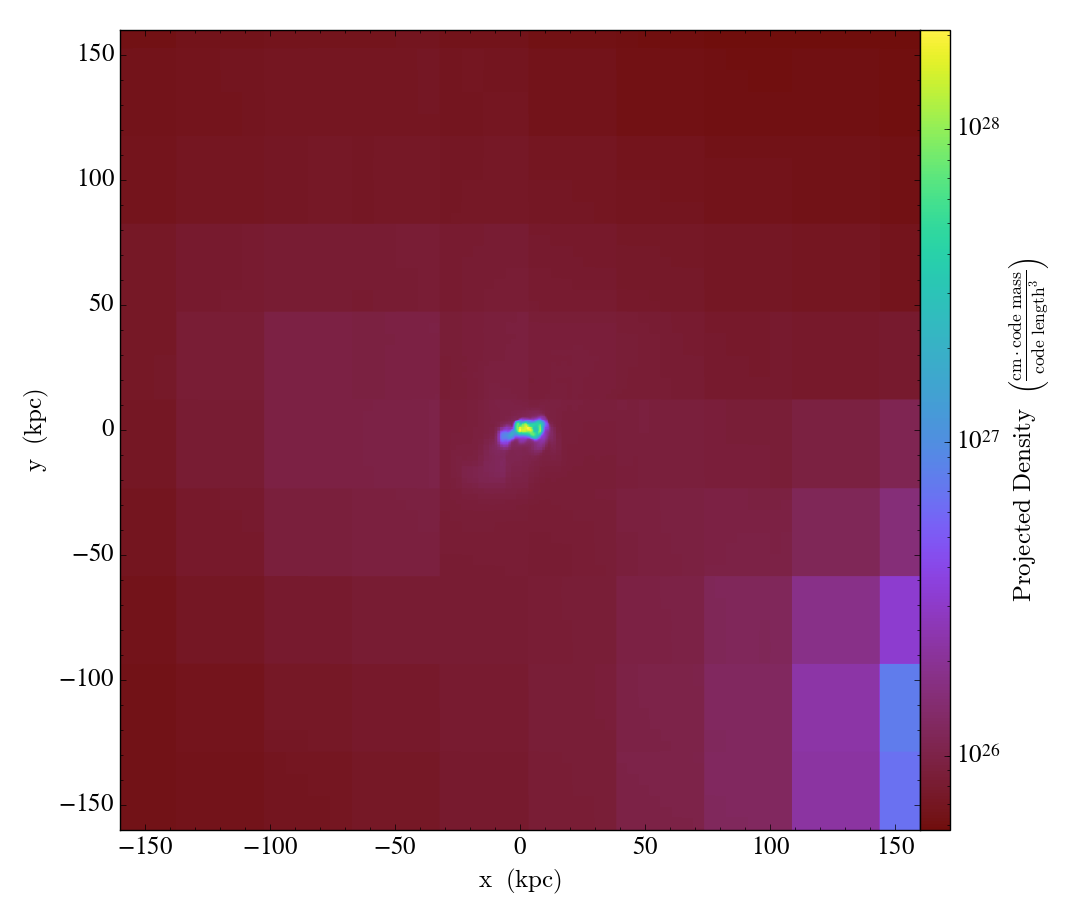

In [69]:
proj = yt.ProjectionPlot(ds,'z','Density',center=pos,width=(320,'kpc'))
proj.show()

yt : [INFO     ] 2017-03-10 14:57:35,768 Projection completed
yt : [INFO     ] 2017-03-10 14:57:35,769 xlim = 0.498135 0.500359
yt : [INFO     ] 2017-03-10 14:57:35,770 ylim = 0.453396 0.455620
yt : [INFO     ] 2017-03-10 14:57:35,773 xlim = 0.498135 0.500359
yt : [INFO     ] 2017-03-10 14:57:35,774 ylim = 0.453396 0.455620
yt : [INFO     ] 2017-03-10 14:57:35,776 Making a fixed resolution buffer of (('gas', 'H_p0_number_density')) 800 by 800



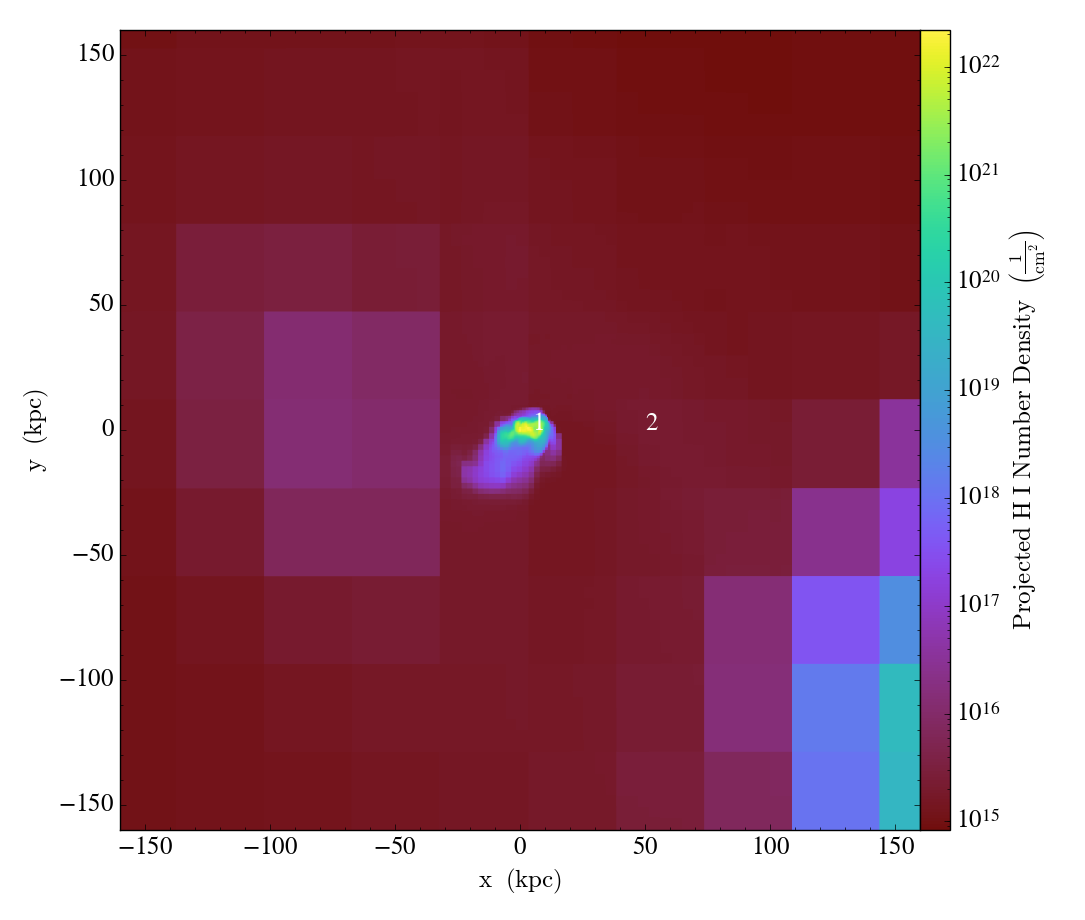

In [82]:
proj = yt.ProjectionPlot(ds,'z',('gas', 'H_p0_number_density'),center=pos,width=(320,'kpc'))
proj.annotate_text(ray_start,'1')#,text_args={'color':'black'})
proj.annotate_text(ray_start2,'2')#,text_args={'color':'black'})
proj.show()

#### So I've now checked all of the things that I can think to compare and it all checks out.

For the enzo simulation at least, yt/trident seem to be doing things consistently and reasonably. So I don't know what's happening with Gadget.